# 1. Setup

Standard imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

Reading our data

In [2]:
register = pd.read_csv("register.csv")
rooms = pd.read_csv("rooms.csv")

# 2. Feature Engineering

- Summing the amount column for the same room and the same month to get the total energy consumed in a month
- Left Joining register and rooms dataframes

In [3]:
grouped = register.groupby(["legal_entity", "service_category", "room_id", "month"])["amount"].sum().reset_index()
joined = pd.merge(grouped, rooms, on="room_id", how="left")
joined.head()

,legal_entity,service_category,room_id,month,amount,building_id,room_area,build_year,building_floors,building_type,building_func,x_coord,y_coord
0,False,Dvinarė kaina,005f6379f5dc0e1,2018-11-01,0.74,0a425666b45790e,45.1,1968-01-01,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0
1,False,Dvinarė kaina,005f6379f5dc0e1,2018-12-01,0.74,0a425666b45790e,45.1,1968-01-01,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0
2,False,Dvinarė kaina,005f6379f5dc0e1,2019-01-01,0.63,0a425666b45790e,45.1,1968-01-01,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0
3,False,Dvinarė kaina,005f6379f5dc0e1,2019-02-01,0.63,0a425666b45790e,45.1,1968-01-01,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0
4,False,Dvinarė kaina,005f6379f5dc0e1,2019-03-01,0.63,0a425666b45790e,45.1,1968-01-01,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0


- Dropping useless columns like room_id, building_id, because they logically don't have an impact on the target column, or we don't want to rely on them for a prediction.
- Converting datetime columns to numerical columns

In [4]:
dropped = joined.drop(["room_id", "building_id", "building_type"], axis=1)

dropped["build_year"] = pd.to_datetime(dropped["build_year"])
dropped["build_year"] = dropped["build_year"].dt.year

dropped["month"] = pd.to_datetime(dropped["month"])
dropped["month"] = dropped["month"].dt.month

dropped.head()

,legal_entity,service_category,month,amount,room_area,build_year,building_floors,building_func,x_coord,y_coord
0,False,Dvinarė kaina,11,0.74,45.1,1968.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0
1,False,Dvinarė kaina,12,0.74,45.1,1968.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0
2,False,Dvinarė kaina,1,0.63,45.1,1968.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0
3,False,Dvinarė kaina,2,0.63,45.1,1968.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0
4,False,Dvinarė kaina,3,0.63,45.1,1968.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0


Selecting rows only for a certain category

In [61]:
filtered = dropped[dropped["service_category"] == "Šiluma"]
filtered.drop(['service_category'], axis=1, inplace=True)
len(filtered), len(dropped)
filtered.head()

C:\Users\zygim\AppData\Local\Temp\ipykernel_9496\491170069.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered.drop(['service_category'], axis=1, inplace=True)


,legal_entity,month,amount,room_area,build_year,building_floors,building_func,x_coord,y_coord
6670598,False,11,676.0647,50.1,1987.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,453840.0,6198465.0
6670599,False,12,994.0728,50.1,1987.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,453840.0,6198465.0
6670600,False,1,1189.3836,50.1,1987.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,453840.0,6198465.0
6670601,False,2,926.7941,50.1,1987.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,453840.0,6198465.0
6670602,False,3,887.8715,50.1,1987.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,453840.0,6198465.0


Removing negative energy amounts (doesn't make sense?), also considered removing outliers, but I don't think they are errors and there's very few of them, but it would be bad to remove them as they might represent buildings that have different functions. If you look at the top consumers of energy it's generally hospitals, clinics and administrative buildings, which represent a very small subset of the data.

In [ ]:
filtered = filtered[filtered["amount"] > 0]

Splitting dataset into features and target

In [7]:
X, y = filtered.drop(["amount"], axis=1), filtered["amount"]

Spliting dataset into train and test splits, dataset is very large so we can afford a smaller fraction of the dataset to be allocated to evaluation

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
len(X_train), len(X_test)

(3001829, 157991)

# 3. Cleaning, Normalization

Using column transformer and various encoders to prepare data for modelling

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ("imp", SimpleImputer()),
    ("scaler", StandardScaler())
])

int_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
])

ohe_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

ord_pipeline = Pipeline([
    ("ord", OrdinalEncoder()),
    ("imp", SimpleImputer(strategy="most_frequent")),
])

num_cols = ["room_area", "x_coord", "y_coord"]
int_cols = ["build_year", "building_floors", "month"]
ohe_cols = ["building_func"]
ord_cols = ["legal_entity"]

processor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("int", int_pipeline, int_cols),
    ("ohe", ohe_pipeline, ohe_cols),
    ("ord", ord_pipeline, ord_cols)
])

Applying the transformations to our data

In [38]:
X_train_proc = pd.DataFrame(processor.fit_transform(X_train))
X_test_proc = pd.DataFrame(processor.transform(X_test))

feat_names = processor.get_feature_names_out()
X_train_proc.columns = feat_names
X_test_proc.columns = feat_names

Final result looks like this:

In [11]:
X_train_proc.head(3)

,num__room_area,num__x_coord,num__y_coord,int__build_year,int__building_floors,int__month,ohe__building_func_Administracinė,ohe__building_func_Gamybos,ohe__building_func_Gydymo,ohe__building_func_Gyvenamasis (individualus pastatas),...,ohe__building_func_Kultūros,ohe__building_func_Maitinimo,ohe__building_func_Mokslo,ohe__building_func_Prekybos,ohe__building_func_Religinės,ohe__building_func_Sandėliavimo,ohe__building_func_Sporto,ohe__building_func_Transporto,ohe__building_func_Viešbučių,ord__legal_entity
0,-0.016947,0.722492,-2.677047,1972.0,5.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.007234,-3.670173,3.243656,1982.0,5.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.008523,-0.066517,-0.272363,1980.0,5.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4. Modelling

Using XGBoost model, as gradient boosted decision trees usually work best for tabular datasets

Evaluating a dummy regressor to use as a baseline for comparison basically meaning it tries to guess the actual values by predicting the mean value of the target, RMSE = 3697, MAE = 543

In [62]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train_proc, y_train)

# Predict on the test set
y_pred = dummy_regressor.predict(X_test_proc)

# Evaluate the performance
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f"Root Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Root Mean Squared Error: 3697.534404304074
Mean Absolute Error: 543.0611177577291


In [13]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()
xgb_model.fit(X_train_proc, y_train, eval_set=[(X_test_proc, y_test)], verbose=True)

[0]	validation_0-rmse:2903.84815
[1]	validation_0-rmse:2378.79734
[2]	validation_0-rmse:2060.72644
[3]	validation_0-rmse:1853.72721
[4]	validation_0-rmse:1723.53746
[5]	validation_0-rmse:1599.78921
[6]	validation_0-rmse:1528.05465
[7]	validation_0-rmse:1486.31342
[8]	validation_0-rmse:1441.44610
[9]	validation_0-rmse:1341.12229
[10]	validation_0-rmse:1276.43971
[11]	validation_0-rmse:1230.53731
[12]	validation_0-rmse:1185.68774
[13]	validation_0-rmse:1183.70222
[14]	validation_0-rmse:1171.46554
[15]	validation_0-rmse:1160.88159
[16]	validation_0-rmse:1131.17089
[17]	validation_0-rmse:1127.18391
[18]	validation_0-rmse:1107.60978
[19]	validation_0-rmse:1096.36539
[20]	validation_0-rmse:1088.23683
[21]	validation_0-rmse:1083.95424
[22]	validation_0-rmse:1072.04921
[23]	validation_0-rmse:1069.20516
[24]	validation_0-rmse:1062.25364
[25]	validation_0-rmse:1044.89498
[26]	validation_0-rmse:1040.15818
[27]	validation_0-rmse:1034.42411
[28]	validation_0-rmse:1026.88960
[29]	validation_0-rmse:1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_preds = xgb_model.predict(X_test_proc)
print(mean_absolute_error(y_test.reset_index(drop=True), y_preds))

154.37184747709767


So for the model it performs really well on smaller target values, because there are way more samples to train on, and the MAE shows that. It's around 150 for the entire model, on the other hand the RMSE is about 800 which makes sense, because the model performs poorly on edge cases where there are only a few samples and RMSE is more susceptible to outliers, but it's important to leave them as they're not errors, and they don't really affect the performance for the smaller target ranges.

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

for i in range(1000, 30000, 1000):
    y_test_proc = y_test.reset_index(drop=True)
    indices = (y_test_proc < i) & (y_test_proc > i-1000) 
    y_test_proc = y_test_proc[indices]
    X_tests_proc = X_test_proc[indices]
    y_preds = xgb_model.predict(X_tests_proc)
    print(f"MAE of {i-1000} to {i} is {mean_absolute_error(y_test_proc, y_preds)}, sample length: {len(y_test_proc)}")

MAE of 0 to 1000 is 102.18356460663969, sample length: 129158
MAE of 1000 to 2000 is 186.11000895458702, sample length: 26122
MAE of 2000 to 3000 is 927.9874698527474, sample length: 744
MAE of 3000 to 4000 is 2037.6719220355353, sample length: 139
MAE of 4000 to 5000 is 2288.589825257524, sample length: 83
MAE of 5000 to 6000 is 2776.4504805582687, sample length: 45
MAE of 6000 to 7000 is 2928.987087157282, sample length: 53
MAE of 7000 to 8000 is 2235.795528871954, sample length: 42
MAE of 8000 to 9000 is 3100.429889453125, sample length: 39
MAE of 9000 to 10000 is 3402.371799817708, sample length: 30
MAE of 10000 to 11000 is 4270.340107463728, sample length: 28
MAE of 11000 to 12000 is 3129.6663120757, sample length: 29
MAE of 12000 to 13000 is 3883.32264986413, sample length: 23
MAE of 13000 to 14000 is 3369.8112346679686, sample length: 24
MAE of 14000 to 15000 is 3565.492258504464, sample length: 35
MAE of 15000 to 16000 is 3877.252258639706, sample length: 17
MAE of 16000 to 170

In [56]:
len(y_test[(y_test < 2500) & (y_test > 0)])

155874

Most important features plotted

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

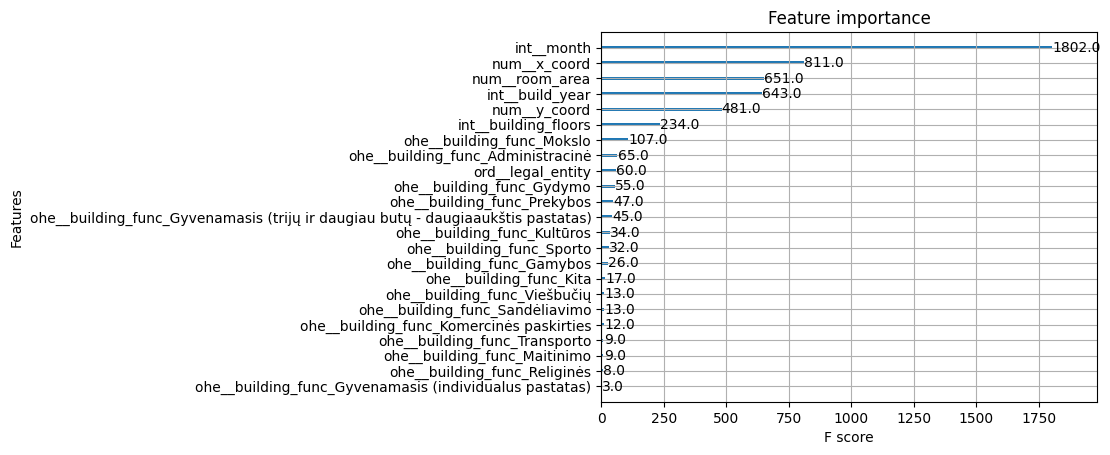

In [63]:
import xgboost as xgb

xgb.plot_importance(xgb_model)

# 5. Hyperparameter optimization using Optuna